In [ ]:
# default_exp funcs.plotting

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Plottings functions

In [ ]:
#export
from decode_fish.imports import *
from mpl_toolkits import axes_grid1
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from decode_fish.funcs.utils import *
from decode_fish.funcs.emitter_io import nm_to_px
from matplotlib.backends.backend_agg import FigureCanvas

In [ ]:
#export
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """ Add a vertical color bar to an image plot """

    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

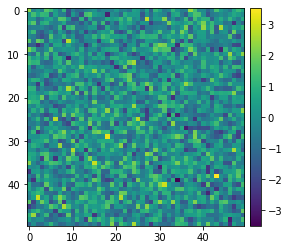

In [ ]:
im = plt.imshow(np.random.normal(size=[50,50]))
add_colorbar(im)

In [ ]:
#export
def plot_3d_projections(volume, proj_func=np.max, size=6, vmax=None, display=True):

    if torch.is_tensor(volume):
        plot_vol = volume.detach().cpu().numpy()
    else:
        plot_vol = volume
        
    for _ in range(plot_vol.ndim - 3):
        plot_vol = plot_vol.squeeze(0)
        
    z,y,x = plot_vol.shape
    
    size_y = size * ((y+z)/y)
    size_x = size * ((1.1*x+z)/x)
        
    fig, ((ax_yx, ax_yz, ax_c), (ax_zx, ax_t1, ax_t2)) = plt.subplots(2, 3, figsize=(size_x,size_y), sharex='col', sharey=False, 
                                                 gridspec_kw={'height_ratios': [y, z], 'width_ratios':[x, z, x/20]})
    plt.subplots_adjust(hspace=0.0,wspace=0.05)
        
    # usually imshow starts at -0.5 so we have to manually change that
    im = ax_yx.imshow(proj_func(plot_vol, 0),vmax=vmax, extent=(0,x,y,0))
    ax_yz.imshow(proj_func(plot_vol, 2).T,vmax=vmax, extent=(0,z,y,0))
    ax_zx.imshow(proj_func(plot_vol, 1),vmax=vmax, extent=(0,x,z,0))
    
    ax_t1.axis('off')
    ax_t2.axis('off')
#     ax_yz.axis('off')
    
    fig.colorbar(im, cax=ax_c)
        
    ax_yx.set_ylabel('y')
    ax_zx.set_xlabel('x')
    ax_zx.set_ylabel('z')
    
    ax_yz.set_xlabel('z')
    ax_yz.set_yticklabels([])
    
    plt.tight_layout()
    
    if not display: plt.close(fig)

    return fig, [ax_yx,ax_zx,ax_yz]

torch.Size([2, 11, 21, 21])


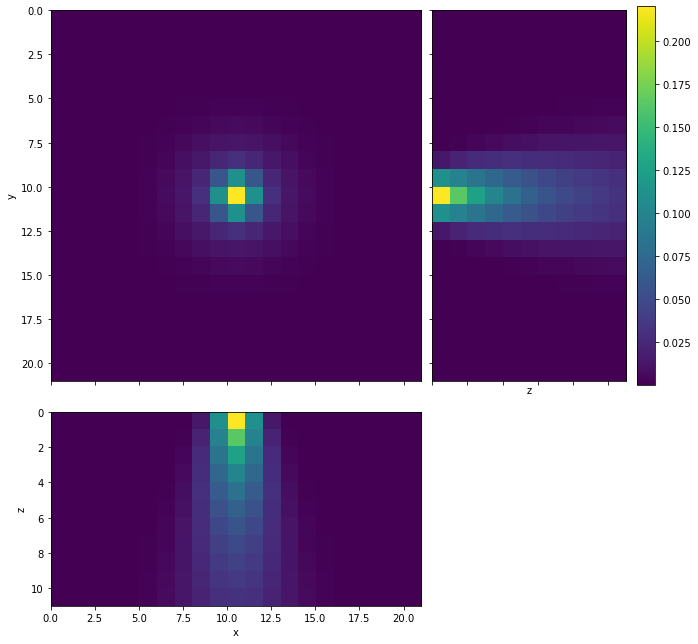

In [ ]:
vol = load_tiff_image('../figures/MF_psf2n.tif')
print(vol.shape)
fig1, _ = plot_3d_projections(vol[0])

In [ ]:
# export
def scat_3d_projections(axes, dfs, px_size_zyx=[1.,1.,1], s_fac=1., labels=None):
    colors = ['red','black','orange']
    markers = ['o','+','x']
    if labels is None:
        labels=[f'DF {i}' for i in range(3)]
    
    if not isinstance(dfs, list):
        dfs = [dfs]
    for i,df in enumerate(dfs):
        df = nm_to_px(df, px_size_zyx)
        axes[0].scatter(df['x'],df['y'], color=colors[i], marker=markers[i], s=10*s_fac, label=labels[i])
        axes[1].scatter(df['x'],df['z'], color=colors[i], marker=markers[i], s=10*s_fac)
        axes[2].scatter(df['z'],df['y'], color=colors[i], marker=markers[i], s=10*s_fac)
    axes[0].legend()
    

def extract_roi(vol_5d: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = vol_5d[crop]
        
    return single_bead, crop

def plot_channels(volume, n_rows=1, dfs=None, codebook=None, proj_func=np.max, size=6, vmax=None, display=True, sc_sz=20):

    volume = cpu(volume)

    for _ in range(volume.ndim - 4):
        volume = volume.squeeze(0)
        
    ch, h, w = volume.shape[0], volume.shape[-2], volume.shape[-1]
    n_cols = int(np.ceil(ch/n_rows))
    
    size_y = size * n_rows
    size_x = size * n_cols
        
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size_x,size_y))
    plt.subplots_adjust(hspace=0.0,wspace=0.05)
    
    colors = sns.color_palette("hls", len(dfs) if dfs is not None else 1)
    markers = ['o', 'X', 'P']
    
    for i in range(n_rows):
        for j in range(n_cols):
            
            curr_ind = i*n_cols + j
            if curr_ind >= len(volume):
                continue
            
            im = axes[i, j].imshow(proj_func(volume[curr_ind], 0),vmax=vmax, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_xlim(0, w)
            axes[i, j].set_ylim(0, h)
            
            if dfs is not None:
                for k, df in enumerate(dfs):
                    sub_df = df[np.array(codebook[df['code_inds'].values][:,curr_ind] > 0)]
                    axes[i, j].scatter(sub_df['x'],sub_df['y'], edgecolors=colors[k], s=sc_sz, marker=markers[k%3], facecolors='none', linewidth=2, label=f'DF_{k}')
    
#     fig.colorbar(im)
    axes[0, 0].legend()
    plt.tight_layout()
    
    if not display: plt.close(fig)

    return fig

In [ ]:
#  center=None, crop_sz=10
# if center is not None:
#         volume, crop = extract_roi(volume, center, crop_sz, 10000)
#         if dfs is not None:
#             dfs = [crop_df(df, crop) for df in dfs]

(2, 2)


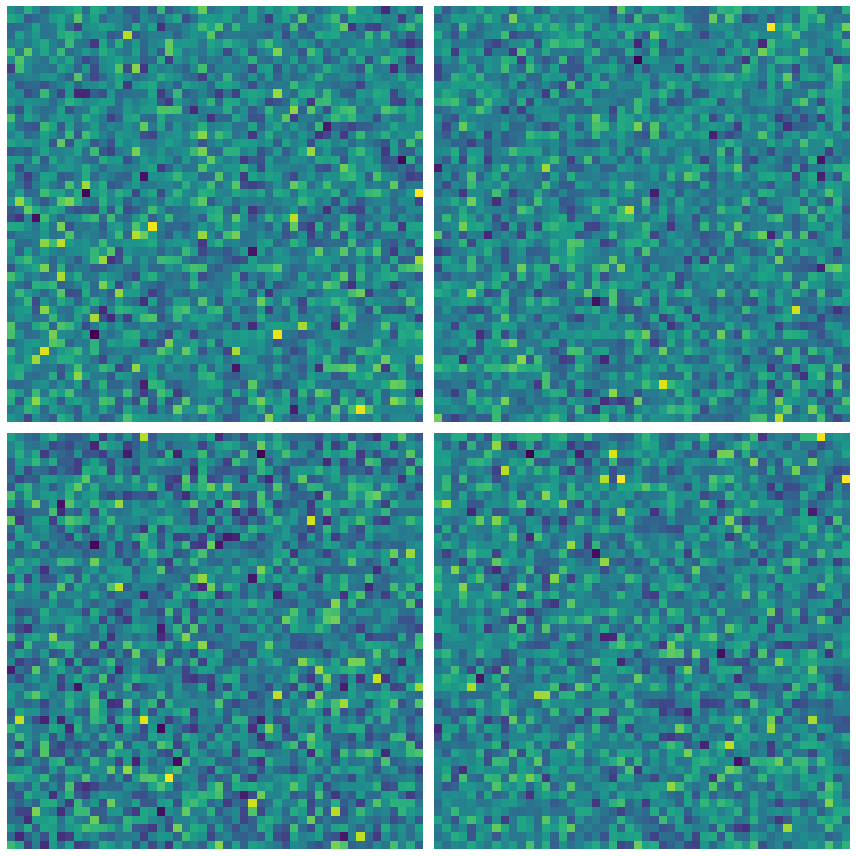

In [ ]:
vol = torch.randn([4,3,50,50])
fig2, _, _ = plot_channels(vol, n_rows = 2, proj_func=np.max)

In [ ]:
# export
def combine_figures(figures, titles, nrows=1, ncols=2, figsize=(10,5)):
    
    imgs = []
    for f in figures:
        canvas = FigureCanvas(f)
        canvas.draw()
        imgs.append(np.array(canvas.renderer.buffer_rgba()))
        
    figure = plt.figure(figsize=figsize)
    axes = figure.subplots(nrows, ncols)
    plt.subplots_adjust(hspace=0.,wspace=0.)

    axes = axes.reshape(-1)
    
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])
        axes[i].axis('off')
        if len(titles) >= len(imgs)-1:
            axes[i].set_title(titles[i])
            
    return figure

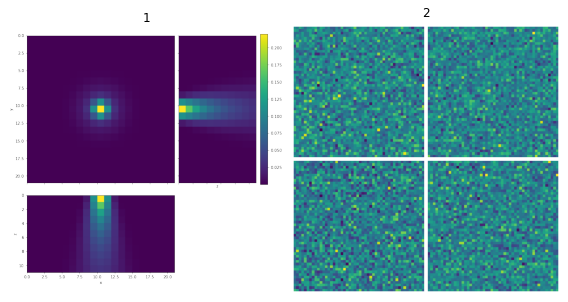

In [ ]:
_ = combine_figures([fig1,fig2], titles=['1','2'])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
